# Group 14 - Project FP01
## Time series anomaly detection - Autoencoder

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 151.63822531700134 seconds ---


In [6]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


## AutoEncoder

In [7]:
from algorithms.autoencoder import AutoEncoder

classifier = AutoEncoder(
    name='AutoEncoder',
    num_epochs=100,
    batch_size=32,
    lr=1e-3,
    hidden_size=32,
    sequence_length=5,
    train_gaussian_percentage=0.25,
    seed=42,
    gpu=None,
    details=True
)

# Train the AutoEncoder on normal data
classifier.fit(X_train)

print("AutoEncoder training completed.")

100%|██████████| 100/100 [00:11<00:00,  8.70it/s]

AutoEncoder training completed.


### Anomaly Detection

Anomaly prediction completed.


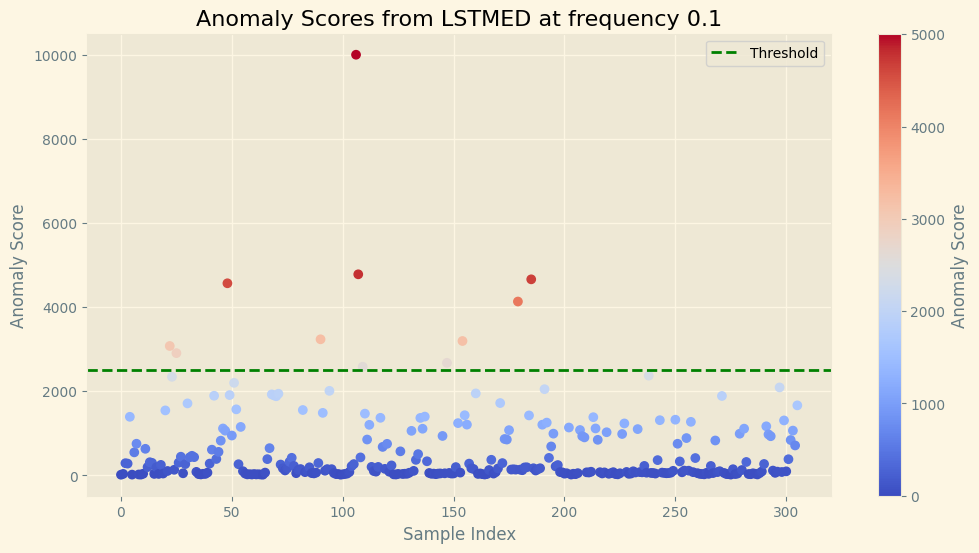

Number of anomalies detected: 11


In [8]:
anomaly_scores, anomalies_detected = plot_anomalies(classifier, X_test, y_test, freq)

In [9]:
anomaly_scores, y_test_binary = compute_metrics(classifier, X_test, y_test)

Anomaly scores statistics:
Mean: 568.0052828795581
Std: 967.4576903535409
Min: 15.863210044549735
Max: 10008.579941296792
ROC AUC Score: 0.7239
Detected anomaly class: 2
F1 Score: 0.2000
Accuracy: 0.9477
Precision: 0.1818
Recall: 0.2222
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       297
           1       0.18      0.22      0.20         9

    accuracy                           0.95       306
   macro avg       0.58      0.60      0.59       306
weighted avg       0.95      0.95      0.95       306



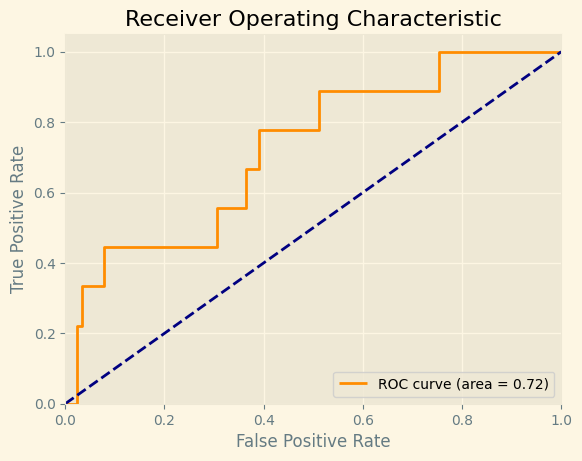

In [10]:
plot_roc_curve(y_test_binary, anomaly_scores)

## Map anomalies to original time series

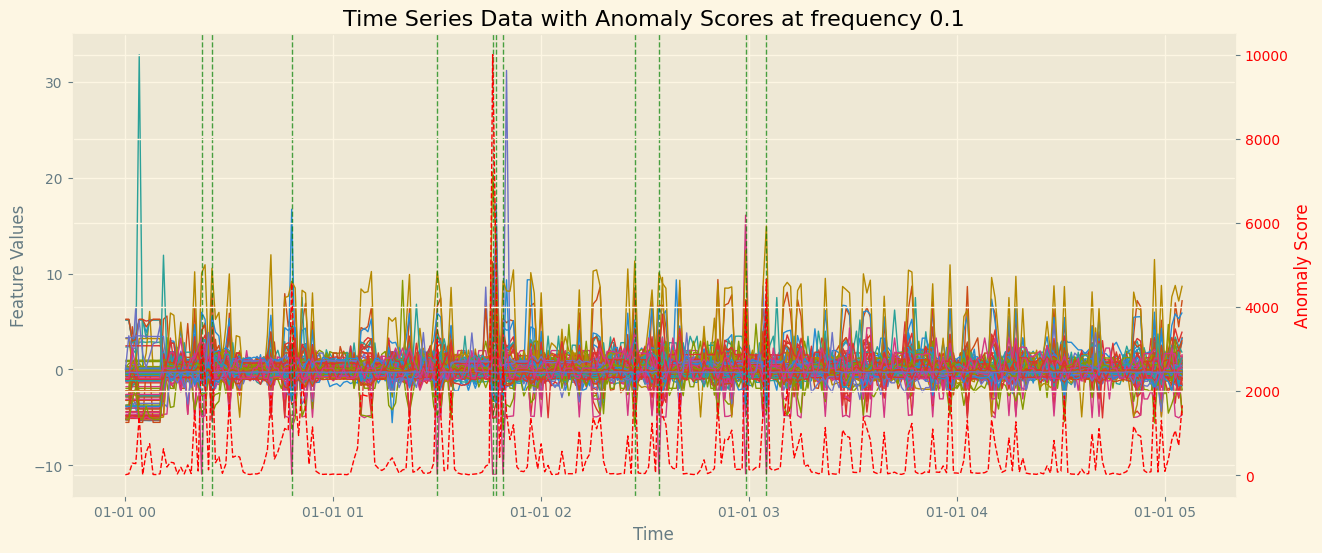

Top 11 Anomalies:
              timestamp  anomaly_score  \
106 2023-01-01 01:46:00   10008.579941   
107 2023-01-01 01:47:00    4784.252919   
185 2023-01-01 03:05:00    4664.763618   
48  2023-01-01 00:48:00    4570.829200   
179 2023-01-01 02:59:00    4136.495262   
90  2023-01-01 01:30:00    3237.884763   
154 2023-01-01 02:34:00    3197.398957   
22  2023-01-01 00:22:00    3078.826505   
25  2023-01-01 00:25:00    2909.201007   
147 2023-01-01 02:27:00    2677.482170   
109 2023-01-01 01:49:00    2584.992179   

     machine_nameKuka Robot_apparent_power-_Average power  \
106                                          -1.885449      
107                                          -1.181816      
185                                          -1.065886      
48                                           -0.707436      
179                                          -1.338344      
90                                           -1.115056      
154                                          -0.85

In [11]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)